In [1]:
import tensorflow as tf
import numpy as np

2024-02-02 18:45:09.859196: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 18:45:09.859262: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 18:45:09.859280: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 18:45:09.890915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
NUM_CLASSES = 100
WIDTH = 32
NUM_CHANNELS = 3
NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_DEV = 100

DATASET = "cifar100"
BASE_DIR = ""  # set to whatever directory you are working/saving in
BATCH_SIZE = 128  # increase batch_size for faster training (if your system does not crash)

## Data loading

In [5]:
def _normalize(X):
  assert X.dtype == np.uint8
  X = X.astype(np.float64)
  X /= 255
  return X

def get_one_hot(targets, nb_classes):
  res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
  return res.reshape(list(targets.shape)+[nb_classes])

def load_standard_cifar100():
  (X_train, Y_train), (X_validation, Y_validation) = tf.keras.datasets.cifar100.load_data()
  X_train = X_train.reshape(X_train.shape[0], WIDTH, WIDTH, NUM_CHANNELS)
  X_validation = X_validation.reshape(X_validation.shape[0], WIDTH, WIDTH, NUM_CHANNELS)

  X_train = _normalize(X_train)
  X_validation = _normalize(X_validation)

  Y_train = Y_train.astype(np.int32)
  Y_validation = Y_validation.astype(np.int32)

  return X_train, Y_train, X_validation, Y_validation

def load_cifar100_train_dev(num_dev=100, selected_dev=None):
  # randomly select and fixed for future (tracin-like strategy but their indices available only for mnist)
  # selected_dev = np.random.randint(0, X_validation.shape[0], num_dev)
  selected_dev = [5214, 2304, 5947, 9428, 2717, 8296, 7736, 8291, 5235, 54,
                  7499, 9590, 3675, 1932, 6646, 8719, 6484, 6306, 3066, 2442,
                  6106, 1949, 4320,  541, 1318, 5967, 2773, 3847, 1152, 9937,
                  7469, 5982, 7644, 5820, 8152, 9518,  601, 3953, 4931, 1924,
                  5342, 5467, 6718, 6779, 2860, 2440, 5480, 1178,  222, 7909,
                  6394, 3511, 8729, 6261, 7192, 9453, 5257, 9077, 6419, 3280,
                  3725, 3601, 8174, 5703, 4954, 9536, 4783, 2234, 7365, 2405,
                  3073, 2780, 7461, 3525, 7573, 6764, 9962, 7527,  992,  315,
                  6260, 9061,  592, 8003, 7594, 1930, 7215, 5124, 7531, 9471,
                  2824, 3533, 6062, 3946, 5246, 4440,  414, 3572, 4899, 884]
  X_train, Y_train, X_validation, Y_validation = load_standard_cifar100()
  X_dev = X_validation[selected_dev]
  Y_dev = Y_validation[selected_dev]
  return X_train, Y_train, X_dev, Y_dev

In [6]:
# X_train, Y_train, X_dev, Y_dev = load_cifar10_train_dev()

# conduct exploration based on memorization
# select dev set based on memorization scores
# first 25 high-mem (>0.9), next 25 med-mem (0.4-0.6) and last 50 low-mem (<0.1) instances
selected_dev = [ 1075, 34033,  5493, 40363, 30042,  5626, 41505, 37982,  7970, 6576, 25030, 39984,   535, 12051, 25953, 36214, 36037, 20184, 36003, 24186, 25619, 48576, 38498, 36517, 30093, 49770,  5601, 7162, 42005, 29670, 29525,  7144,  2103, 32021, 21286,  9826, 13950, 31891, 33396, 11636, 33512, 16989, 46732,  8562, 24911, 22121,  7299, 37157, 41412, 26147, 39450, 28933,  4457, 39655, 20024,   914, 14761, 14404,  5321,  8839, 29797, 15728, 42305, 28441, 32679,   963, 16498, 25505, 43944, 46180, 12346, 14728, 4344, 24199, 18249, 26364, 47172, 22227, 38149, 34972, 30768, 33000, 43948,  5161, 10436, 41042, 39750, 45714, 26910, 11997, 8599, 11824, 19886, 17737, 37730,  1417,  6623, 33458, 38684, 39262]
X_train, Y_train, X_test, Y_test = load_standard_cifar100()
X_dev, Y_dev = X_train[selected_dev], Y_train[selected_dev]

In [7]:
Y_train = np.squeeze(np.array(Y_train))
Y_test = np.squeeze(np.array(Y_test))
Y_dev = np.squeeze(np.array(Y_dev))

In [8]:
print(X_train.shape, X_test.shape, X_dev.shape, Y_train.shape, Y_test.shape, Y_dev.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3) (50000,) (10000,) (100,)


## Model training

In [9]:
def dnn_custom(inp_dim, out_dim, dnn='resnet50', train_full=False, weights='imagenet', dropout_pct=0.25, use_upsampling=False):
    inp_dim_orig = inp_dim
    if use_upsampling:
      inp_dim = (224,224,3)
    if dnn=='resnet50':
      dnn_model = tf.keras.applications.ResNet50(weights=weights, include_top=False, input_shape=inp_dim)
    elif dnn=='mobilenet':
      dnn_model = tf.keras.applications.MobileNet(weights=weights, include_top=False, input_shape=inp_dim)
    elif dnn=='mobilenetv3':
      dnn_model = tf.keras.applications.MobileNetV3Small(weights=weights, include_top=False, input_shape=inp_dim)
    elif dnn=='efficientnetb0':
      dnn_model = tf.keras.applications.EfficientNetB0(weights=weights, include_top=False, input_shape=inp_dim)
    elif dnn=='efficientnetb3':
      dnn_model = tf.keras.applications.EfficientNetB3(weights=weights, include_top=False, input_shape=inp_dim)

    if not train_full:
      for layer in dnn_model.layers:
          if isinstance(layer, tf.keras.layers.BatchNormalization):
              layer.trainable = True
          else:
              layer.trainable = False

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=inp_dim_orig))
    if use_upsampling & inp_dim_orig[0] != 224:
      model.add(tf.keras.layers.UpSampling2D(size=(224/inp_dim_orig[0], 224/inp_dim_orig[0]), interpolation='bilinear'))
    model.add(dnn_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(dropout_pct))
    model.add(tf.keras.layers.Dense(out_dim*16, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(out_dim, activation='softmax'))
    return model

In [10]:
# not using when upsampling since ~0.75 accuracy without it
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(X_train)

In [ ]:
BASE_DNN = 'resnet50'  # 'efficientnetb0'
EPOCHS = 1000
saved_epochs = [1, 10, 100, 200, 300, 500, 600, 700, 750, 800, 900, 1000]

start_epoch = 0
for e in saved_epochs:
    try:
        clf = tf.keras.models.load_model(f"{BASE_DIR}/{DATASET}_{BASE_DNN}_{e}e.h5")
        start_epoch = e
    except:
        break
    
if start_epoch == 0:
    clf = dnn_custom(inp_dim=(32,32,3), out_dim=NUM_CLASSES, dnn=BASE_DNN, dropout_pct=0, train_full=False, use_upsampling=True)
    clf.compile(
        optimizer='Adam', 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
    )

print(start_epoch)
for i in range(start_epoch+1,EPOCHS+1):
  if (i%10) == 0:
    print(i)
  clf.fit(X_train, Y_train, epochs=1, batch_size=BATCH_SIZE, validation_data=(X_test, Y_test), verbose=2)
  if i in saved_epochs:
    clf.save(f"{BASE_DIR}/{DATASET}_{BASE_DNN}_{i}e.h5")

2023-11-19 17:12:09.423944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78953 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0


900


2023-11-19 17:12:36.221521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-11-19 17:12:41.201493: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2ad524191e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 17:12:41.201557: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-19 17:12:41.205945: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-19 17:12:41.511504: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 - 76s - loss: 0.0030 - accuracy: 0.9990 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.2441 - val_accuracy: 0.7728 - val_sparse_top_k_categorical_accuracy: 0.9444 - 76s/epoch - 194ms/step
391/391 - 55s - loss: 0.0023 - accuracy: 0.9992 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.2951 - val_accuracy: 0.7712 - val_sparse_top_k_categorical_accuracy: 0.9439 - 55s/epoch - 141ms/step
391/391 - 55s - loss: 0.0022 - accuracy: 0.9992 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.3211 - val_accuracy: 0.7710 - val_sparse_top_k_categorical_accuracy: 0.9454 - 55s/epoch - 141ms/step
391/391 - 55s - loss: 0.0025 - accuracy: 0.9992 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.3774 - val_accuracy: 0.7684 - val_sparse_top_k_categorical_accuracy: 0.9442 - 55s/epoch - 142ms/step
391/391 - 55s - loss: 0.0036 - accuracy: 0.9989 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 3.3714 - val_accuracy: 0.7686 - val_sparse_top_k_categorical_accurac

## RPS

### Model loading

In [53]:
trained_epochs = 1000
base_dnn = 'resnet50'

MODEL_DIR = f"{BASE_DIR}/{DATASET}_{base_dnn}_{trained_epochs}e.h5"
model = tf.keras.models.load_model(MODEL_DIR)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1600)              3278400   
                                                                 
 batch_normalization (Batch  (None, 1600)              6

In [54]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

313/313 [==============================] - 5s 16ms/step


In [55]:
print(f"Accuracy (Train): {(P_train.argmax(axis=1) == np.squeeze(Y_train)).mean()}")
print(f"Accuracy (Test): {(P_test.argmax(axis=1) == np.squeeze(Y_test)).mean()}")

Accuracy (Train): 0.9995
Accuracy (Test): 0.7692


## Getting hidden outputs

In [56]:
features_input = tf.keras.Input(shape=(WIDTH, WIDTH, NUM_CHANNELS))
labels_input = tf.keras.Input(shape=(NUM_CLASSES,))

In [57]:
model.layers

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1600)              3278400   
                                                                 
 batch_normalization (Batch  (None, 1600)              6

In [59]:
h_x = features_input
for layer_num in range(len(model.layers) - 2):
  h_x = model.layers[layer_num](h_x, training=False)
last_layer_model = tf.keras.Model(inputs=features_input, outputs=h_x)
last_layer_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1600)              3278

In [60]:
X_hidden_outputs = last_layer_model.predict(X_train)
X_hidden_outputs.shape

1563/1563 [==============================] - 23s 14ms/step


(50000, 1600)

## Representer

In [61]:
import time

In [62]:
class Linear(tf.keras.Model):
  def __init__(self, num_classes):
    super(Linear, self).__init__()
    self.fc = tf.keras.layers.Dense(
        num_classes,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))

  def call(self, inputs):
    return self.fc(inputs)

def run():
  ###############################################
  start_time = int(time.time())

  num_train_examples = NUM_TRAIN
  tensorboard_summary_dir = (f"{BASE_DIR}/tmp/{DATASET}/original/representer/{start_time}/tensorboard/")
  checkpoint_dir = (f"{BASE_DIR}/tmp/{DATASET}/original/representer/{start_time}/checkpoint/")

  epochs = 100   # more epochs do not improve accuracy, or fidelity really, (at least with current hyperparams)
  lr = 1.0
  num_classes = NUM_CLASSES
  ###################
  train_batch_size = 50000  # GRADIENT DESCENT NOT BATCH VARIANT
  # train_batch_size = 60000
  # strategy_str = "one_gpu"
  # tpu_address = "v3-8"
  lam = 0.001
  checkpoint_frequency = 250
  ###############################################
  # strategy = get_strategy(strategy_str, tpu_address=tpu_address)
  # if train_batch_size % strategy.num_replicas_in_sync != 0:
  #   raise ValueError(
  #       'Train batch size must be divisible by number of replicas : {}'.format(
  #           strategy.num_replicas_in_sync))
  train_steps_per_epoch = num_train_examples // train_batch_size


  BATCH_SIZE = 200  # SO BATCHING HAPPENING?
  train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(X_hidden_outputs, dtype=tf.float32), P_train)).take(num_train_examples).batch(BATCH_SIZE, drop_remainder=True)
  # OPTIMIZING ON PREDICTED PROB INSTEAD OF GROUND TRUTH BECAUSE PRETRAINED MODEL

  final_layer = Linear(num_classes)
  optim = tf.keras.optimizers.SGD(learning_rate=lr)

  train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
  train_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
      1, 'train_accuracy', dtype=tf.float32)
  grad_norm = tf.keras.metrics.Mean('grad_norm', dtype=tf.float32)

  final_layer_checkpoint = tf.train.Checkpoint(model=final_layer)

  train_iter = iter(train_ds)

  @tf.function
  def train_step(inputs):
    hidden_outputs, probs = inputs
    with tf.GradientTape() as tape:
      logits = final_layer(hidden_outputs)
      loss = tf.keras.losses.categorical_crossentropy(
          probs, logits, from_logits=True)
      loss = tf.reduce_mean(loss)

      l2_loss = lam * tf.add_n([
          tf.nn.l2_loss(v)
          for v in final_layer.trainable_weights])
      loss += l2_loss   # L2 REGULARIZATION HAPPENING

    grads = tape.gradient(loss, final_layer.trainable_weights)
    g_norm = tf.norm(tf.concat([grads[0],
        tf.expand_dims(grads[1], axis=0)], axis=0))
    beta = tf.constant(0.5)  #???
    t = tf.constant(10.0)   #???

    # NOT FULLY SURE ABOUT THIS PART
    while tf.constant(True):
      new_logits = tf.matmul(hidden_outputs, (final_layer.trainable_weights[0]-t*grads[0])) + (
          (final_layer.trainable_weights[1]-t*grads[1]))
      new_loss = tf.keras.losses.categorical_crossentropy(
          probs, new_logits, from_logits=True)
      new_loss = tf.reduce_mean(new_loss)
      new_l2_loss = lam * tf.add_n([
          tf.nn.l2_loss(v-t*g)
          for g, v in zip(grads, final_layer.trainable_weights)])
      new_loss += new_l2_loss
      if tf.less_equal(new_loss - loss + t * g_norm *  g_norm * 0.5, 0):
        break
      t *= beta
      if tf.less(t, 0.0000000001):
        t *= 0.0
        break
    optim.apply_gradients(zip([t * grad for grad in grads], final_layer.trainable_weights))


    train_loss.update_state(loss)
    grad_norm.update_state(g_norm)
    train_accuracy.update_state(probs, logits)

  for epoch in range(1, epochs + 1):
    train_loss.reset_states()
    train_accuracy.reset_states()
    grad_norm.reset_states()
    train_steps_in_current_epoch = 0
    for inputs in train_ds:
      train_step(inputs)
      steps = min(train_steps_per_epoch,
                  train_steps_per_epoch - train_steps_in_current_epoch)

      train_steps_in_current_epoch += steps

    print('Done training epoch %s' % (epoch))
    print('train_loss %f' % (train_loss.result()))
    print('train_accuracy %f' % (train_accuracy.result()))
    print('grad_norm %f' % (grad_norm.result()))

    # Save checkpoint
    if epoch % checkpoint_frequency == 0:
      checkpoint_name = final_layer_checkpoint.save(
          os.path.join(checkpoint_dir,
              'model-{epoch:04d}.ckpt'.format(epoch=epoch)))
      print('Saved checkpoint to %s', checkpoint_name)
    print('==================================================')

    current_steps = epoch * train_steps_per_epoch
  return final_layer

final_layer = run()

Done training epoch 1
train_loss 1.343753
train_accuracy 0.684340
grad_norm 12.221407
Done training epoch 2
train_loss 0.299407
train_accuracy 0.931360
grad_norm 5.899184
Done training epoch 3
train_loss 0.166836
train_accuracy 0.970200
grad_norm 4.102801
Done training epoch 4
train_loss 0.104777
train_accuracy 0.987640
grad_norm 2.893910
Done training epoch 5
train_loss 0.073545
train_accuracy 0.994640
grad_norm 2.129493
Done training epoch 6
train_loss 0.057391
train_accuracy 0.997180
grad_norm 1.687411
Done training epoch 7
train_loss 0.046283
train_accuracy 0.998700
grad_norm 1.329750
Done training epoch 8
train_loss 0.038768
train_accuracy 0.999400
grad_norm 1.067249
Done training epoch 9
train_loss 0.033449
train_accuracy 0.999660
grad_norm 0.863714
Done training epoch 10
train_loss 0.029571
train_accuracy 0.999740
grad_norm 0.706098
Done training epoch 11
train_loss 0.026952
train_accuracy 0.999760
grad_norm 0.596932
Done training epoch 12
train_loss 0.024757
train_accuracy 0.99

In [63]:
def get_one_hot(targets, nb_classes):
  res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
  return res.reshape(list(targets.shape)+[nb_classes])

In [64]:
### want to work with entire test data as dev set for intersection effect
X_dev = X_test
Y_dev = Y_test

In [65]:
Y_dev_one_hot = get_one_hot(Y_dev, NUM_CLASSES)
Y_train_one_hot = get_one_hot(Y_train, NUM_CLASSES)

Y_train_one_hot = np.squeeze(Y_train_one_hot)
Y_dev_one_hot = np.squeeze(Y_dev_one_hot)

In [66]:
probs = tf.nn.softmax(final_layer(X_hidden_outputs))
weight_matrix = probs-Y_train_one_hot

X_dev_hidden_outputs = last_layer_model.predict(X_dev)

val_feature = X_dev_hidden_outputs
train_feature = X_hidden_outputs

val_feature_n = (val_feature.T / np.linalg.norm(val_feature, axis=1)).T
train_feature_n = (train_feature.T / np.linalg.norm(train_feature, axis=1)).T

alpha_js = []
representer_vals = []
sim_vals, sim_vals_normalized = [], []
for test_point in range(X_dev.shape[0]):
  target_class = np.squeeze(Y_dev[test_point])
  alpha_j = weight_matrix[:, target_class]
  sim_val = np.sum(train_feature * val_feature[test_point,:], axis=1)
  sim_val_normalized = np.sum(train_feature_n * val_feature_n[test_point,:], axis=1)
  representer_val = alpha_j * np.sum(train_feature * val_feature[test_point,:], axis=1)

  alpha_js.append(alpha_j)
  representer_vals.append(-1*representer_val)
  sim_vals.append(sim_val)
  sim_vals_normalized.append(sim_val_normalized)

np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_{trained_epochs}e.npy", weight_matrix, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_j_{trained_epochs}e.npy", alpha_js, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_representer_val_{trained_epochs}e.npy", representer_vals, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_{trained_epochs}e.npy", sim_vals, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_normalized_{trained_epochs}e.npy", sim_vals_normalized, allow_pickle=True)

313/313 [==============================] - 4s 14ms/step


## C10-like Visualization

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
rcParams_ticks = {'figure.dpi': 200.0, 'xtick.bottom': True, 'ytick.left': False, 'legend.loc': 'lower right', 'legend.fancybox': True,
                  'axes.edgecolor': 'grey', 'axes.xmargin': 0.05, 'text.usetex': False}
sns.set_theme(style='ticks', rc=rcParams_ticks)

In [22]:
# alpha_js.shape
X_dev.shape

(100, 32, 32, 3)

In [16]:
trained_epochs = 100
base_dnn = 'resnet50'

alpha = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_{trained_epochs}e.npy", allow_pickle=True)
alpha_js = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_j_{trained_epochs}e.npy", allow_pickle=True)
representer_vals = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_representer_val_{trained_epochs}e.npy", allow_pickle=True)
sim_vals = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_{trained_epochs}e.npy", allow_pickle=True)
sim_norm_vals = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_normalized_{trained_epochs}e.npy", allow_pickle=True)

In [17]:
alpha_js.shape  # num_test x num_train
sparsity_thresh = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9]
num_total = np.prod(alpha_js.shape)
for t in sparsity_thresh:
    num_gt_t = (np.abs(alpha_js) > t).sum()
    pct_gt_t = (num_gt_t / num_total) * 100
    pct_lt_t = 100 - pct_gt_t
    print(f"{pct_lt_t} percent of is almost 0 (<={t})")
    
# A CDF plot can be helpful visualization then!
# Different CDF for model trained for different epochs
# but threshold values very low

87.61486 percent of is almost 0 (<=1e-05)
94.37138 percent of is almost 0 (<=0.0001)
97.81552 percent of is almost 0 (<=0.001)
99.43506 percent of is almost 0 (<=0.01)
99.96316 percent of is almost 0 (<=0.1)
99.99554 percent of is almost 0 (<=0.5)
99.99932 percent of is almost 0 (<=0.9)


In [18]:
for t in sparsity_thresh:
    num_gt_t = (np.abs(alpha_js) > t).sum()
    pct_gt_t = (num_gt_t / num_total) * 100
    print(f"{pct_gt_t} percent of training instances are influential (Grad>{t})")

12.38514 percent of training instances are influential (Grad>1e-05)
5.62862 percent of training instances are influential (Grad>0.0001)
2.18448 percent of training instances are influential (Grad>0.001)
0.56494 percent of training instances are influential (Grad>0.01)
0.03684 percent of training instances are influential (Grad>0.1)
0.00446 percent of training instances are influential (Grad>0.5)
0.00068 percent of training instances are influential (Grad>0.9)


92
28
38
81
90


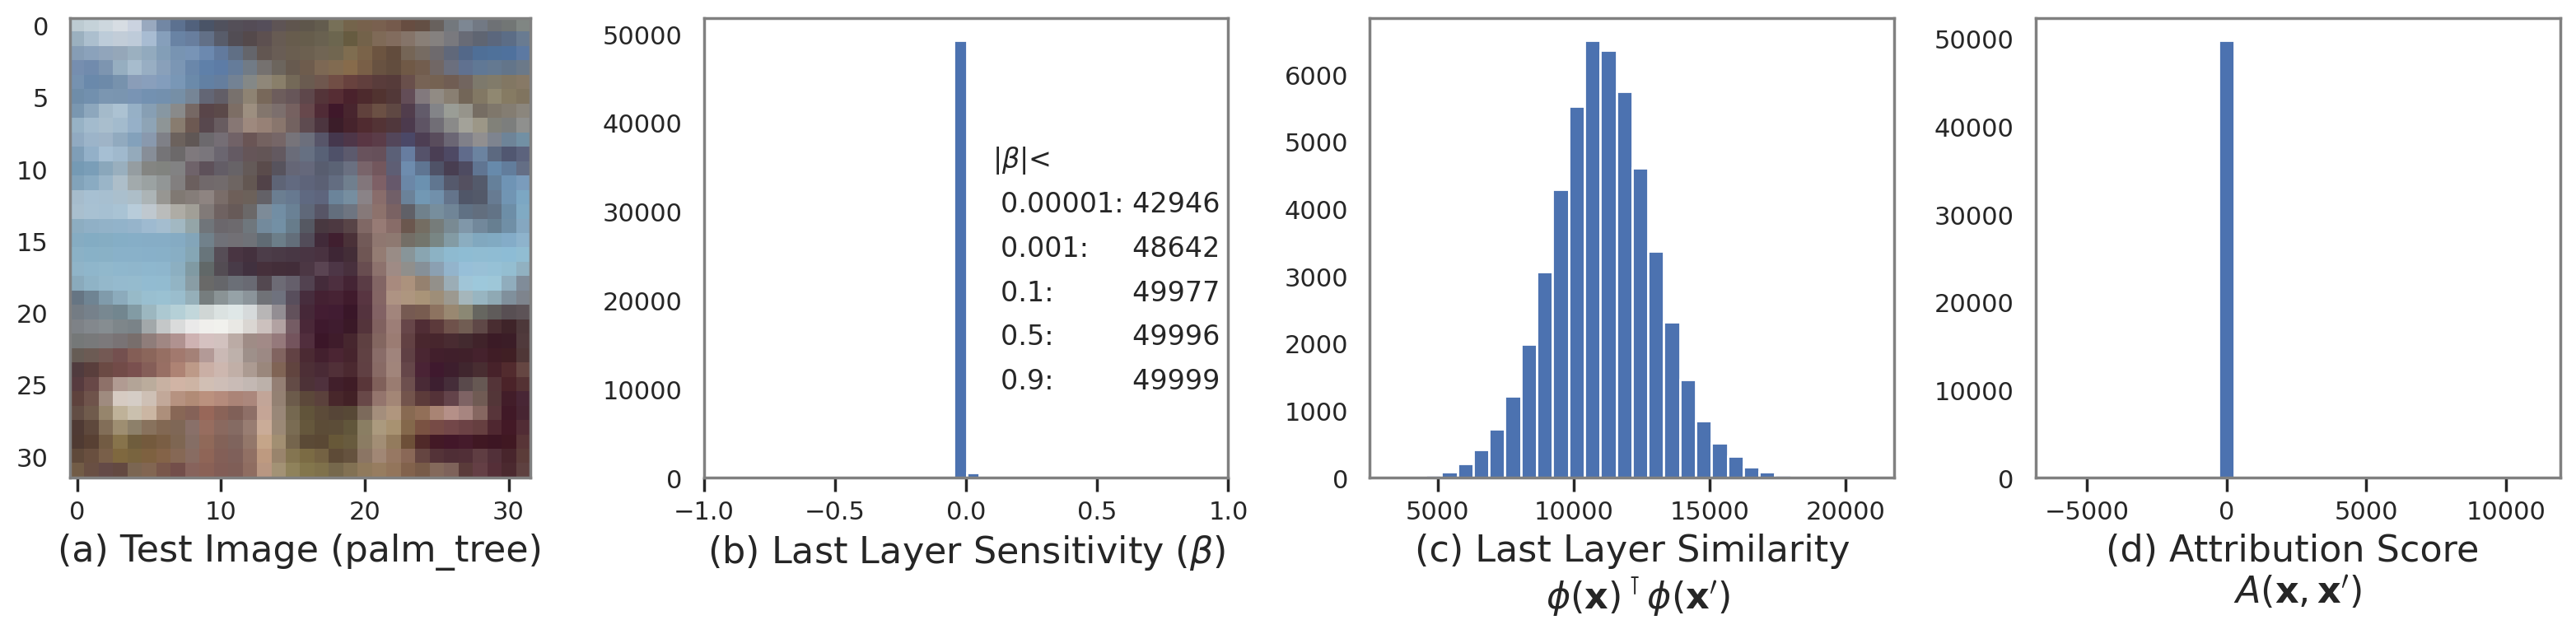

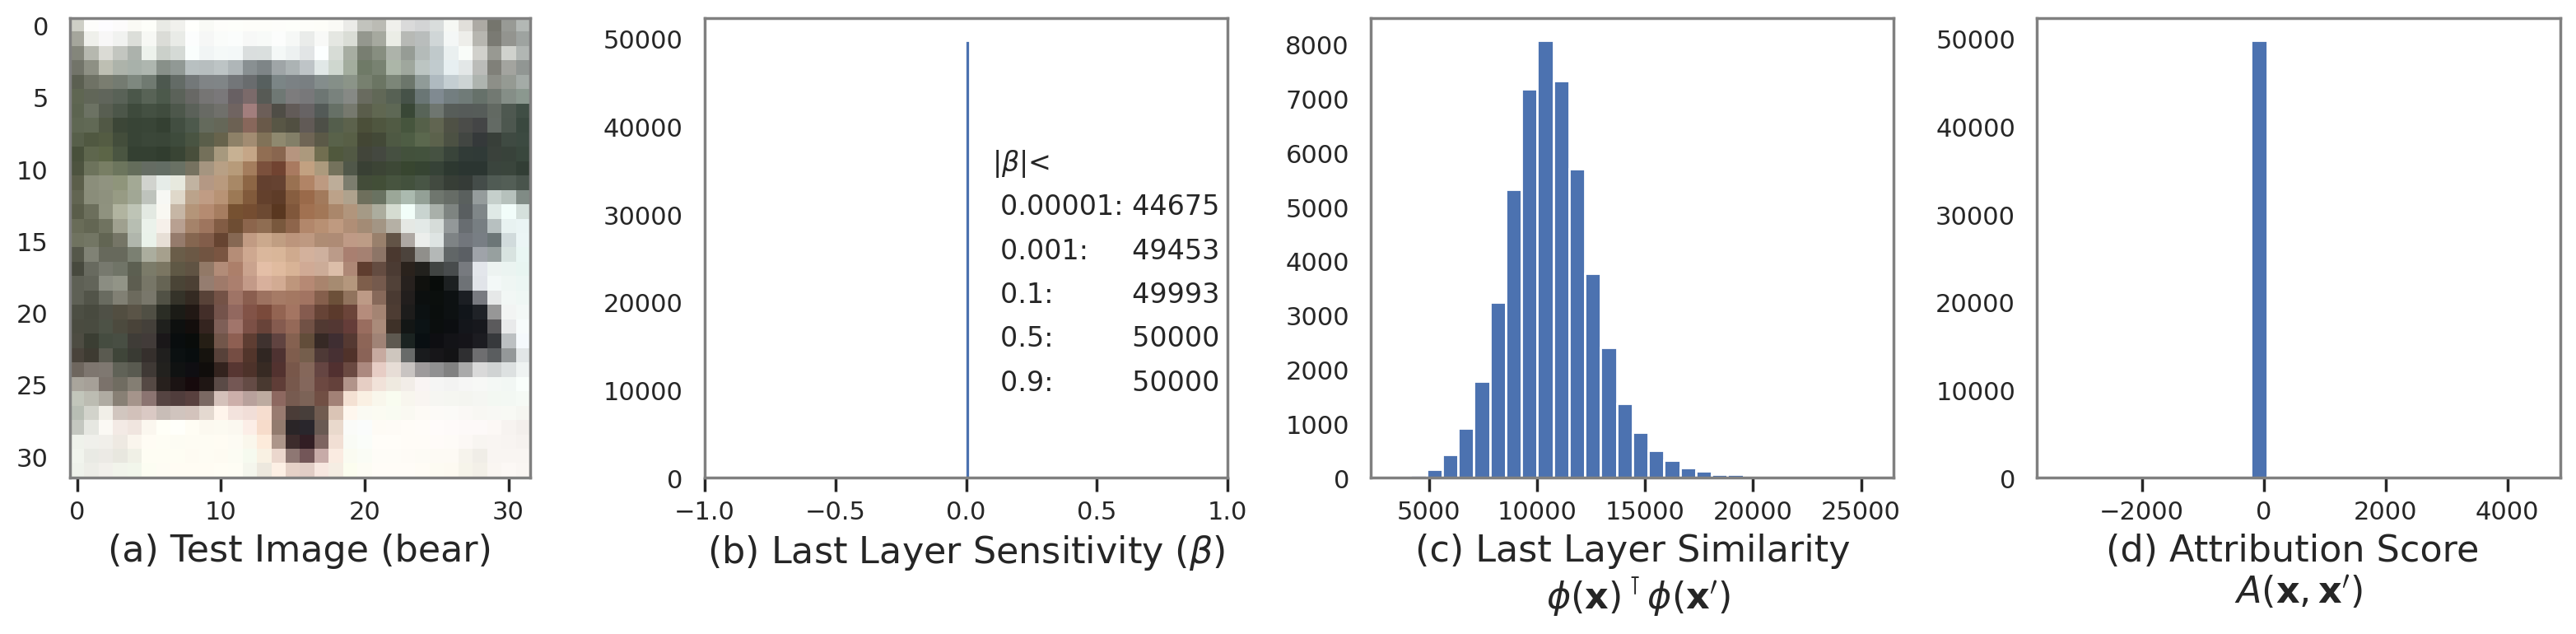

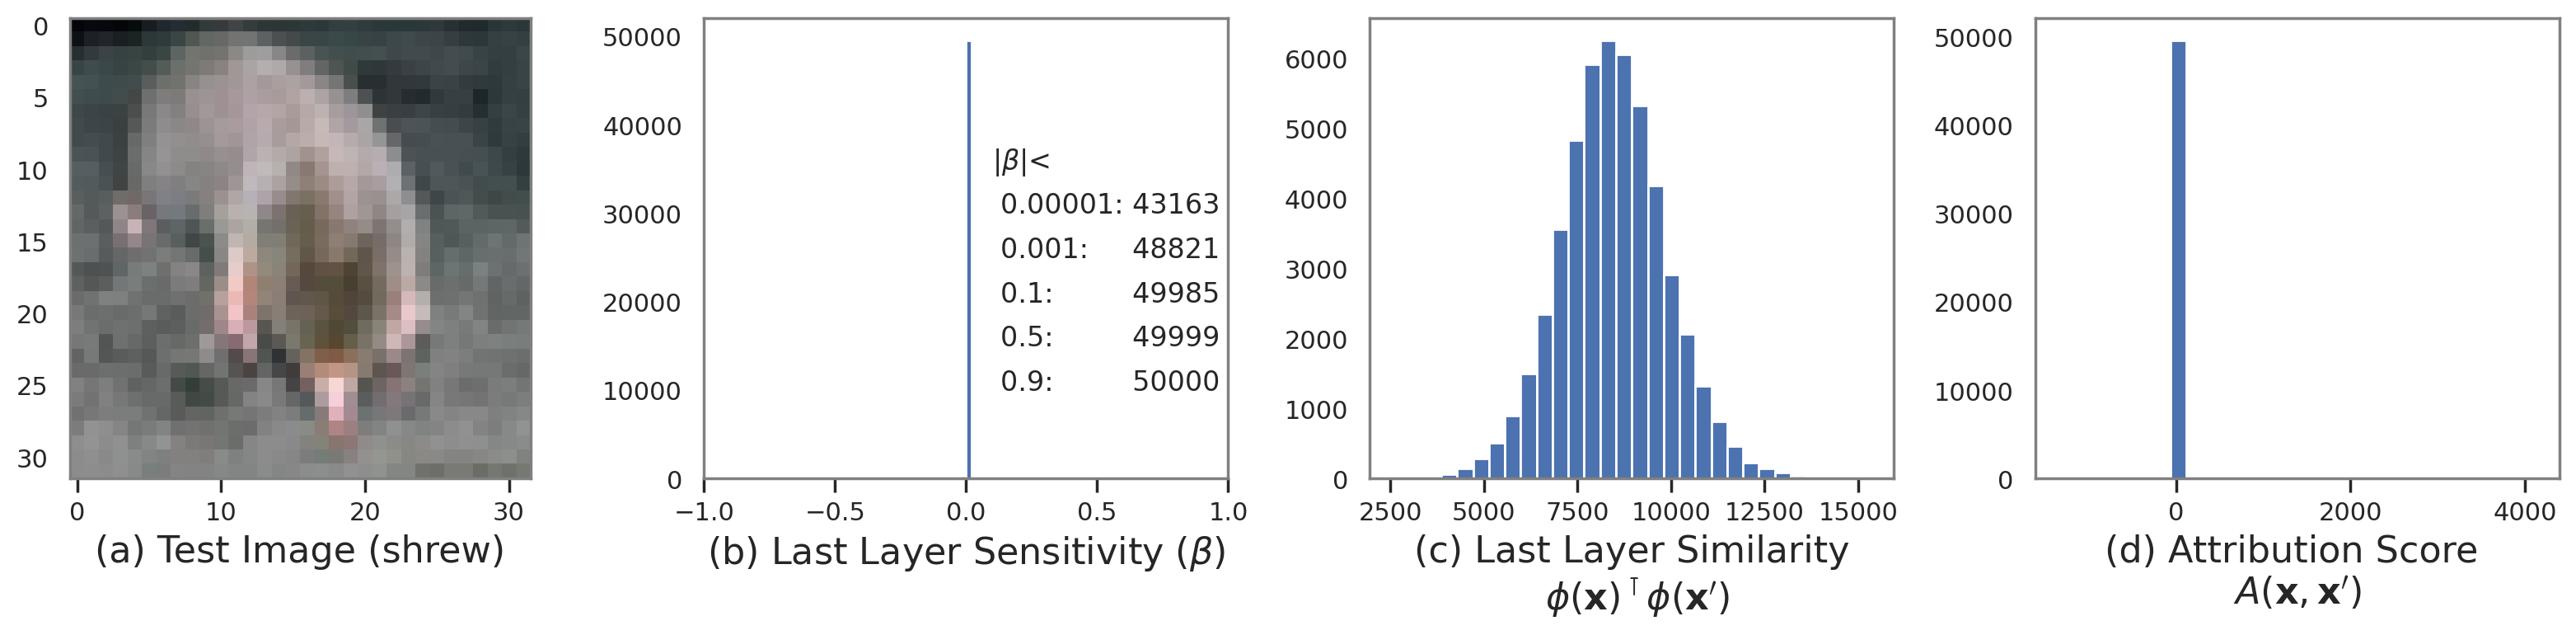

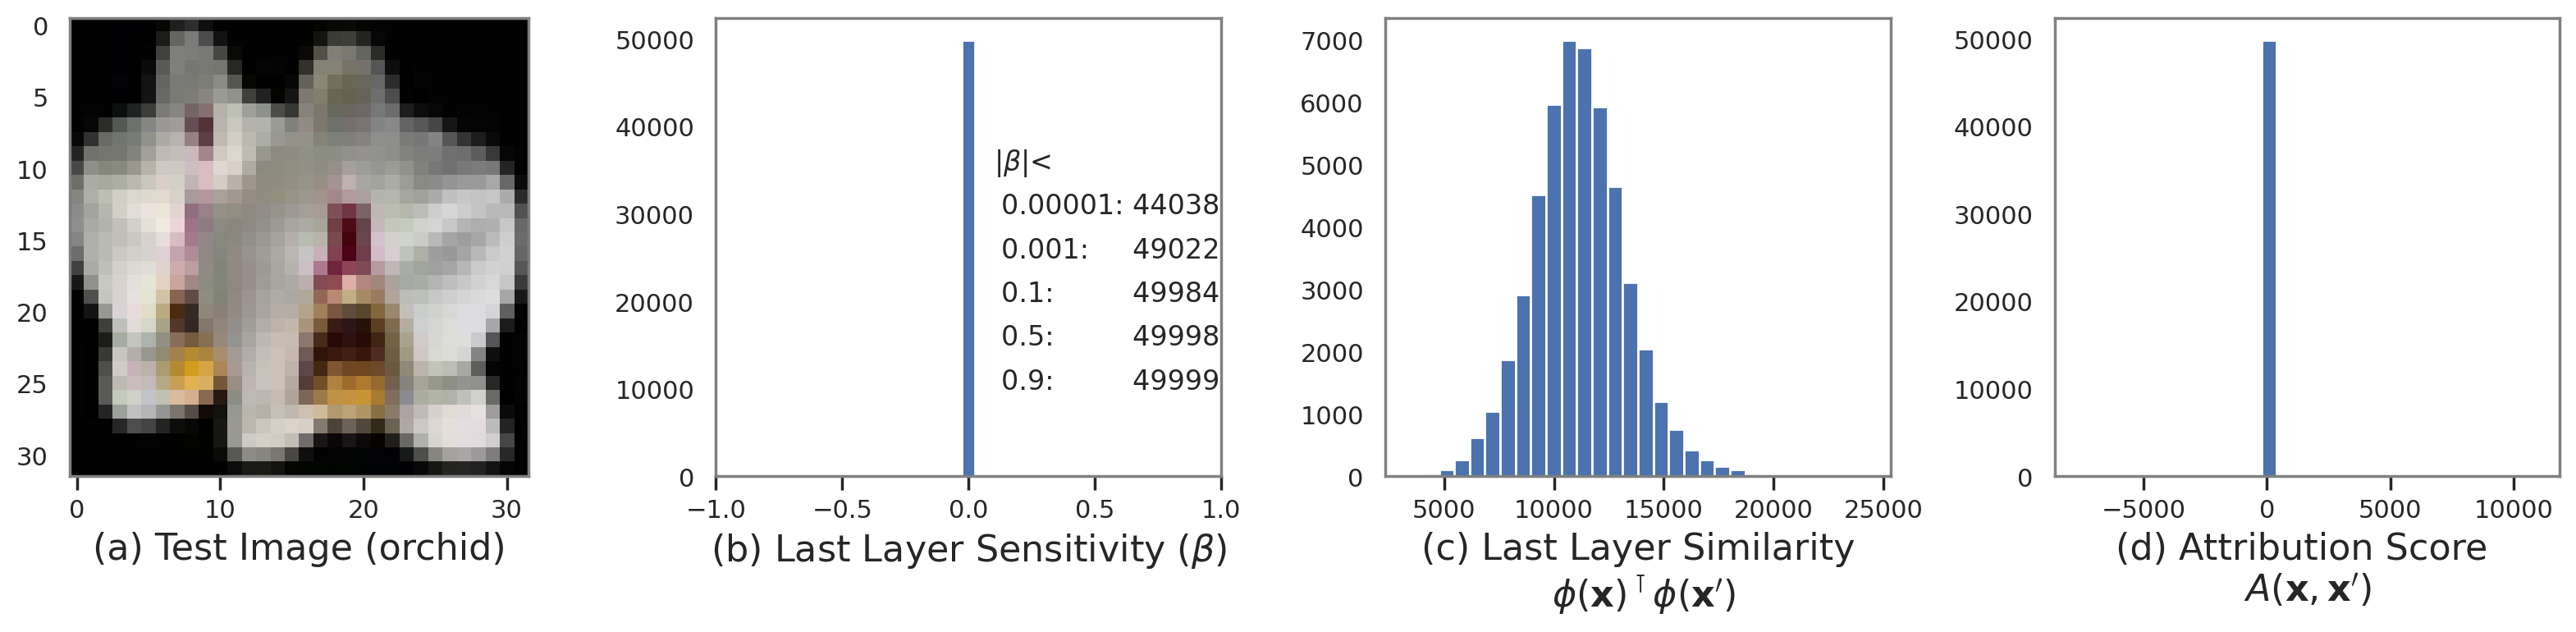

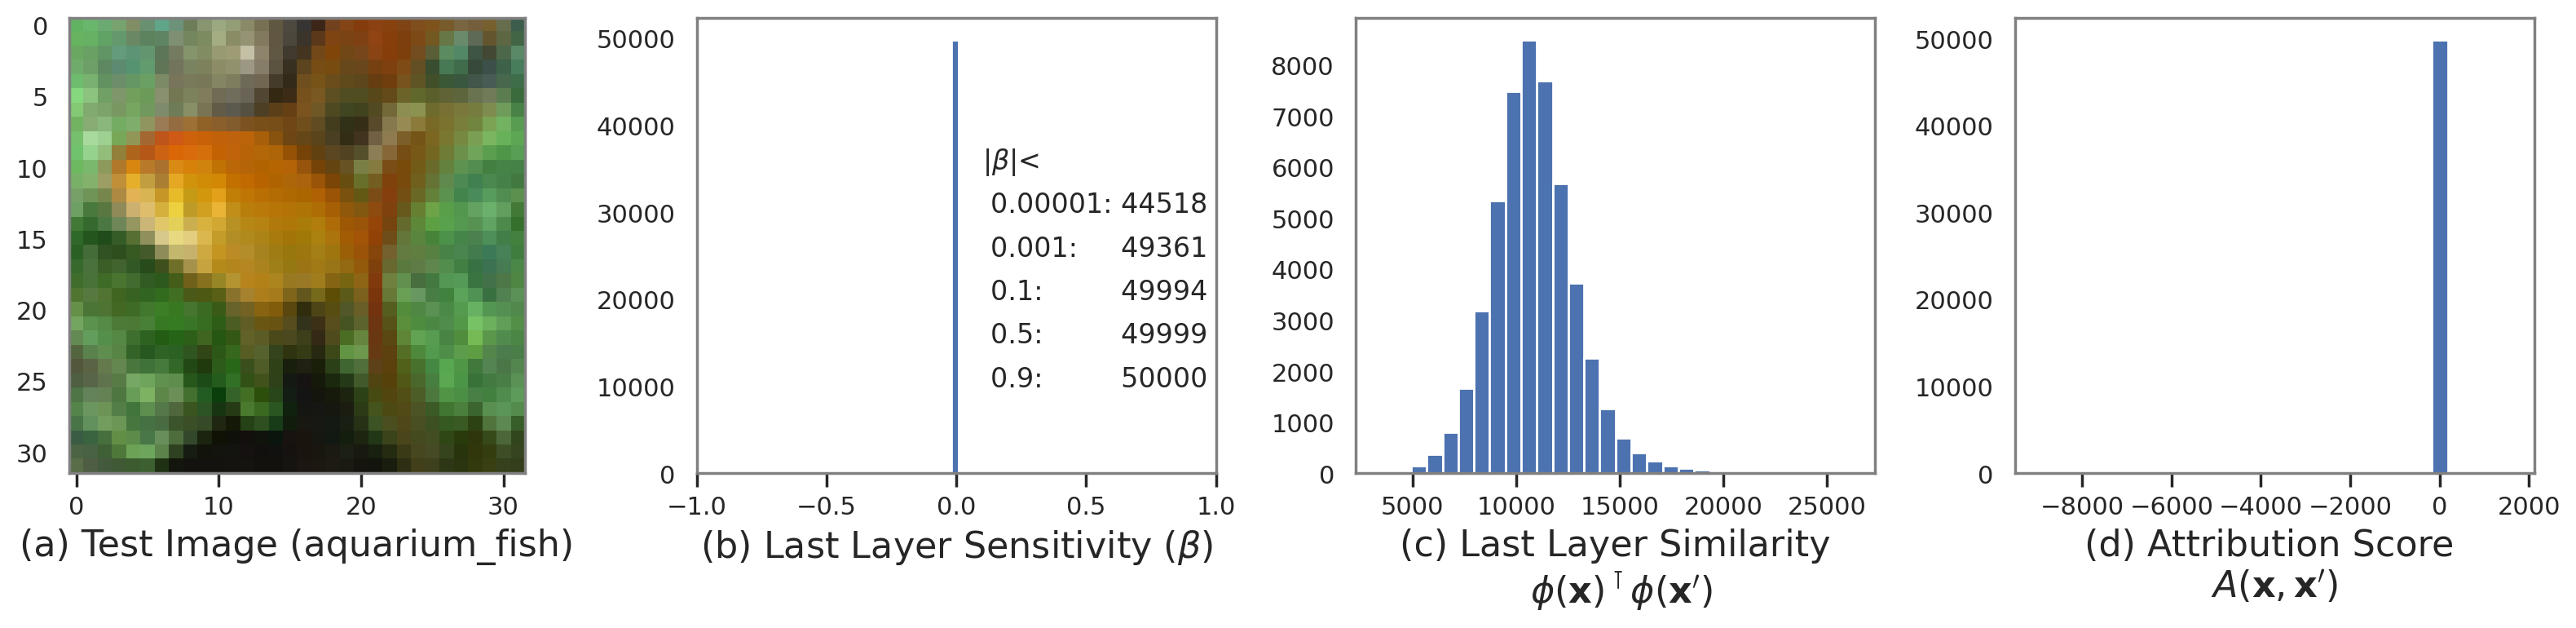

In [25]:
PLOT_HIGH_VAL = False
n_bins = 30
ix_rand = np.random.choice(100, 5, replace=False)
for i in ix_rand:
  print(i)
  x = X_dev[i].copy()
  alpha = alpha_js[i].copy()
  rep_val = representer_vals[i].copy()
  sim_val = sim_vals[i].copy()
  # sim_val = sim_norm_vals[i].copy()

  if PLOT_HIGH_VAL:
    ix_high = np.where(np.abs(alpha) > 0.1)
    alpha = alpha[ix_high]
    rep_val = rep_val[ix_high]
    sim_val = sim_val[ix_high]

  plt.figure(figsize=(16,4))

  plt.subplot(1, 4, 1)
  plt.imshow(x)
  plt.xlabel(f"(a) Test Image ({label_dict[np.squeeze(Y_dev)[i]]})", fontsize=16)

  plt.subplot(1, 4, 2)
  plt.hist(alpha, bins=n_bins)
  # plt.hist(alpha, bins=3)
  abs_alpha = np.abs(alpha)
  plt.xlim((-1,1))
  if not PLOT_HIGH_VAL:
    plt.text(0.1, 35000, r"|$\beta$|<")
    plt.text(0.13, 30000, r"0.00001" + f": {(abs_alpha<0.00001).sum()}")
    plt.text(0.13, 25000, r"0.001" +  f":     {(abs_alpha<0.001).sum()}")
    plt.text(0.13, 20000, r"0.1" + f":         {(abs_alpha<0.1).sum()}")
    plt.text(0.13, 15000, r"0.5" + f":         {(abs_alpha<0.5).sum()}")
    plt.text(0.13, 10000, r"0.9" + f":         {(abs_alpha<0.9).sum()}")
  plt.xlabel(r"(b) Last Layer Sensitivity ($\beta$)", fontsize=16)

  plt.subplot(1, 4, 3)
  plt.hist(sim_val, bins=n_bins)
  plt.xlabel("(c) Last Layer Similarity\n $\phi(\mathbf{x})^\intercal \phi(\mathbf{x'})$", fontsize=16)

  plt.subplot(1, 4, 4)
  plt.hist(rep_val, bins=n_bins)
  abs_rep_val = np.abs(rep_val)
  plt.xlabel("(d) Attribution Score \n$A(\mathbf{x}, \mathbf{x'})$", fontsize=16)

  plt.tight_layout()

  plt.savefig(f"sm_c100_{i}_inp_alp_sim_rep.pdf")
  # plt.savefig(f"{BASE_DIR}/sm_c100_{i}_inp_alp_sim_rep.pdf")